In [1]:
import matplotlib.pyplot as plt
from math import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from datetime import date
import time
import matplotlib.dates as mdates



In [11]:
# Importing data 
cols = ['dt_referencia', 'confirmados', 'recuperados', 'obitos']

df = pd.read_csv('./PE-data.csv', usecols=cols)
df.filter

initial_date = date(2020, 7, 1)
end_date = date(2021, 10, 31)
unix_inital_date = time.mktime(initial_date.timetuple())
unix_end_date = time.mktime(end_date.timetuple())


datetime_series = pd.to_datetime(df['dt_referencia'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df.set_index(datetime_index)
df.drop('dt_referencia',axis=1,inplace=True)


df = df.loc['2020-07-01':'2021-10-31']
print(df)

real_total_pop = 9.278E6

n_days = (end_date - initial_date).days

k = 1e3
t = np.linspace(k, k+n_days, 10000)

r = pd.date_range(start=initial_date, end=end_date)

            confirmados  obitos  recuperados
2020-07-01        61119    4968        41925
2020-07-02        62362    5068        42456
2020-07-03        63457    5116        44314
2020-07-04        65129    5143        44568
2020-07-05        65642    5163        46417
...                 ...     ...          ...
2021-10-27       630520   19990       568818
2021-10-28       630980   20001       569115
2021-10-29       631632   20007       569986
2021-10-30       631892   20018       570246
2021-10-31       632011   20025       570293

[488 rows x 3 columns]


# Abstract
This is a numerical analysis about COVID-19 in Pernambuco. It's going to model the behaviour of the pandemic between 01/07/2020 and 31/10/2021 and forecast the evolution of the pandemic up to 28/02/2022. We wil use a mix between the SIRV and SIRS model with vital dynamics.

# Introduction and Objectives
The COVID-19 pandemic has changed an taken the lives of many people. Being able to forecast and test the outcome of different measures to contain the disease is fundamental to it's erradication and control.
This is why a Numerical Model is so important in this scenario because it's a transparent sandbox where it's possible to test many different measures and alternative realities.

We expect our model to be able to fit the historical data in Pernambuco about the COVID-19 pandemic and then create a _reasonable_ forecast. We also plan to tweak different parameters and see what would happen in those scenarios such as varying $\beta$ (the effective contamination) to model the use of masks.


# Methods
In this draft we are going to model the pandemic with the basic $SIR$ model and we will compare the graph of this model to the actual historical data to tune the $\beta$ and $\gamma$ parameters. We'll also use real data about Pernambuco's population for the $S$, $I$, $R$ values. 

In [3]:
def SIR(u, t):

    N = real_total_pop

    S = u[0]
    I = u[1]
    R = u[2]

    beta = 0.2 / N
    gamma = 0.02

    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]


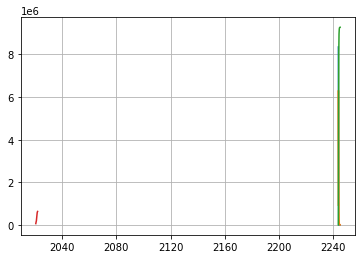

In [12]:
model_pop = real_total_pop 
model_infected = 0.1
u = [model_pop - (model_pop * model_infected), model_pop * model_infected, 0.]

plt.grid()
plt.plot(t, odeint(SIR, u, t))# df['confirmados'])
plt.plot(df['confirmados'])
plt.show()
#plt.plot(t,odeint(SIR, u, t)[:, 1])

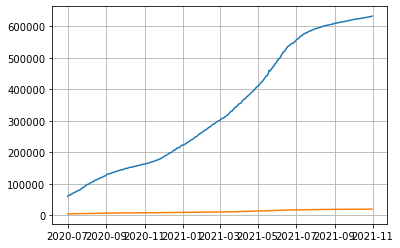

In [6]:

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.plot(df['confirmados'])
plt.plot(df['obitos'])
plt.show()
#plt.gcf().autofmt_xdate()

# Results and Discussion

# Conclusion